This data challenge requires to use plsRglm only in an ensemble model to predict wine quality for both red and white wine. 

During the EDA, I notice that the independent variables are highly correlated, making pls a good choice. However, I also notice that a linear model won't be able to capture the underlying model. I engineered polynomial features with LDA dimensional reduction to capture this non-linearity. 

During model development, I notice that the low to medium quality wine group (quality = 3, 4, 5, 6) and medium to high-quality wine group (quality = 6, 7, 8, 9) have different behavior. Furthermore, as most of the data is with quality 5 or 6, making it very difficult to give a good prediction for data at the two ends (quality = 3, 4 and 8, 9). From the residual plot, I can see that data with quality 3, 4 has prediction values smaller than the real values, which is the opposite for data with quality 7, 8, 9. Therefore, I decided to build two regression models, one for low to medium quality wine, one for medium to a high-quality wine. If predicted quality < 6, use the result from the first model. If predicted quality > 6, use the result from the second model. If the result is in between, using the average of the two models.

# Load library

In [41]:
library(tidyverse)
library(caret)
library(rdist)
library(MASS)
library(plsRglm)

# Read all data

#### As requested, the red wine and white wine data are merged to one. 

I was considering if I should keep the labels of wine color for the training set. Then before the final prediction, I can first do a classification on wine color. In this way, I can increase the accuracy by building two  models for red wine and white wine seperatedly. 

Eventually, I decided not seperate the two dataset for four reasons:

1. The requirements said to merge the two datasets meaning the training dataset may not have the wine color as label


2. When looking at the LDA visualization results, even combining the two datasets, it looks similar with the two seperatedly dataset


3. The red wine data is only more than 1000


4. My prediction results seem similar between the dataset of red, white or red and white combined

In [1]:
script_dir = '/Users/yizheng/project_python3/inisght/AFS'

data_red = read.csv(paste(script_dir, "winequality-red.csv", sep = "/"), header = TRUE, sep = ";")
data_white = read.csv(paste(script_dir, "winequality-white.csv", sep = "/"), header = TRUE, sep = ";")
data <- rbind(data_red, data_white)

In [4]:
head(data)

fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5
7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5
11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5


# Split the data to train and validation

During the model development, I used cross validation to fine tune the model parameters. For the fine tuned model, I used different seed for random spilting the data to train and test test and record the performance of model. 

In [4]:
# Split the data into training and test set
set.seed(200)
training.samples <- data$quality %>%
createDataPartition(p = 0.8, list = FALSE)

train.data  <- data[training.samples, ]
test.data <- data[-training.samples, ]

In [5]:
X_train = subset(train.data, select = -c(quality) )
y_train = subset(train.data, select = c(quality) )

X_test = subset(test.data, select = -c(quality) )
y_test = subset(test.data, select = c(quality) )

In [6]:
head(X_train)

fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4
7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8
7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8
11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4
7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4


# Normalized the data
Note that this preprocess should be done after the train split and not before. This is because in a real case, the test data is always new data that we won't know before building the model

In [7]:
preProcValues <- preProcess(X_train, method = c("center", "scale"))
X_train_norm <- predict(preProcValues, X_train)
X_test_norm <- predict(preProcValues, X_test)

Include y(quality) in the dataframe so that it fits the format for the later plsRglm prediciton model:

In [8]:
train_norm.data <-X_train_norm 
train_norm.data["quality"] <- y_train$quality
test_norm.data <-X_test_norm
test_norm.data["quality"] <- y_test$quality 

# Feature generation

There are several reason that feature generation is important here:

1. PLS is the only regression model that we can used in this data challenge. PLS is a linear model, which means that if the feature space is non-linear, it won't be able to model it well. 


2. Besides, the advantage of PLS is that it can handle high dimensional feature space, especially when there is collinearlity among the features. That means that we should generate nonlinear features and let the PLS does it job in filtering out the useful features and handle the collinearlity.


3. The task is to use an ensemble model with plsRglm only.  In the plsRglm we have "pls", "pls-glm-Gamma", "pls-glm-gaussian", "pls-glm-inverse.gaussian", "pls-glm-logistic", "pls-glm-poisson", "pls-glm-polr". Usually, an ensemble model has better performance when the model has low correlation, if we only use plsRglm, there is little improvement when stacking different plsRglm models, no to metion there is a penalty term in the number of model I used. Therefore, instead of working on different plsRglm family, I worked on creating different dataset for one plsRglm model to ensemble instead.

### Feature genertion strategy:
I added four features to fit in different models, in total, there are five different dataset I used:
1. raw data
2. normalized data (this found out later no too useful)
3. 2nd order polynomial features + LDA for dimensional reduction while keeping data of different wine quality far from each other but close to the data with the same quality
4. 3rd order polynomial features + LDA
5. kernel function with gaussian shape (this found out later take too long in model traning)

### 1. Polynomial features generation

In [9]:
features_poly <- function(X_original, X_new){

    # This is a funciton to generate polynomial features
    # It multiply each feature of data frame X_new (x1, x2, x3)
    # by each feature in X_original (x1, x2, x3)
    # resulting in new features (x1, x2, x3, x1*x1, x1*x2, x1*x3, x2*x2, x2*x3, x3*x3)
   
    
    new_features <- X_original
    count <- ncol(X_original) # keep the original features before adding new one
    
    for(i in 1:ncol(X_original)){
        for(j in i:ncol(X_new)){
        
        new_features[,count] <- X_original[,i]*X_new[,j]
        count <- count +1
            }
    }
    return(new_features)
}

#### 2nd order polynominal

In [10]:
X_train_poly2 <- features_poly(X_train, X_train) # 2nd order polynominal
X_test_poly2 <- features_poly(X_test, X_test)  # 2nd order polynominal

In [11]:
train_poly2.data <-X_train_poly2 
train_poly2.data["quality"] <- y_train$quality # add y values to the dataset 

test_poly2.data <-X_test_poly2
test_poly2.data["quality"] <- y_test$quality # add y values to the dataset 

In [12]:
head(train_poly2.data)

fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,⋯,V68,V69,V70,V71,V72,V73,V74,V75,V76,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,⋯,3.502278,0.558768,9.37932,12.3201,1.9656,32.994,0.3136,5.264,88.36,5
7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,⋯,3.189760,0.677824,9.76864,10.2400,2.1760,31.360,0.4624,6.664,96.04,5
7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,⋯,3.250220,0.648050,9.77060,10.6276,2.1190,31.948,0.4225,6.370,96.04,5
11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,⋯,3.153680,0.578840,9.78040,9.9856,1.8328,30.968,0.3364,5.684,96.04,6
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,⋯,3.502278,0.558768,9.37932,12.3201,1.9656,32.994,0.3136,5.264,88.36,5
7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,⋯,3.502278,0.558768,9.37932,12.3201,1.9656,32.994,0.3136,5.264,88.36,5


#### 3rd order polynominal

In [13]:
X_train_poly3 <- features_poly(X_train, X_train_poly2) 
X_test_poly3 <- features_poly(X_test, X_test_poly2) 

In [14]:
train_poly3.data <-X_train_poly3
train_poly3.data["quality"] <- y_train$quality

test_poly3.data <-X_test_poly3
test_poly3.data["quality"] <- y_test$quality 

### 2. Linear discriminant analysis (LDA) to generate new features

LDA can be used as a dimensional reduction method, more importantly, it works on seperate the centorid of different classes. In other words, by extracting features using LDA, we can help to seperate the wine data with different quality far away from each other to improve the results

1. LDA for the 2nd order polynomial data

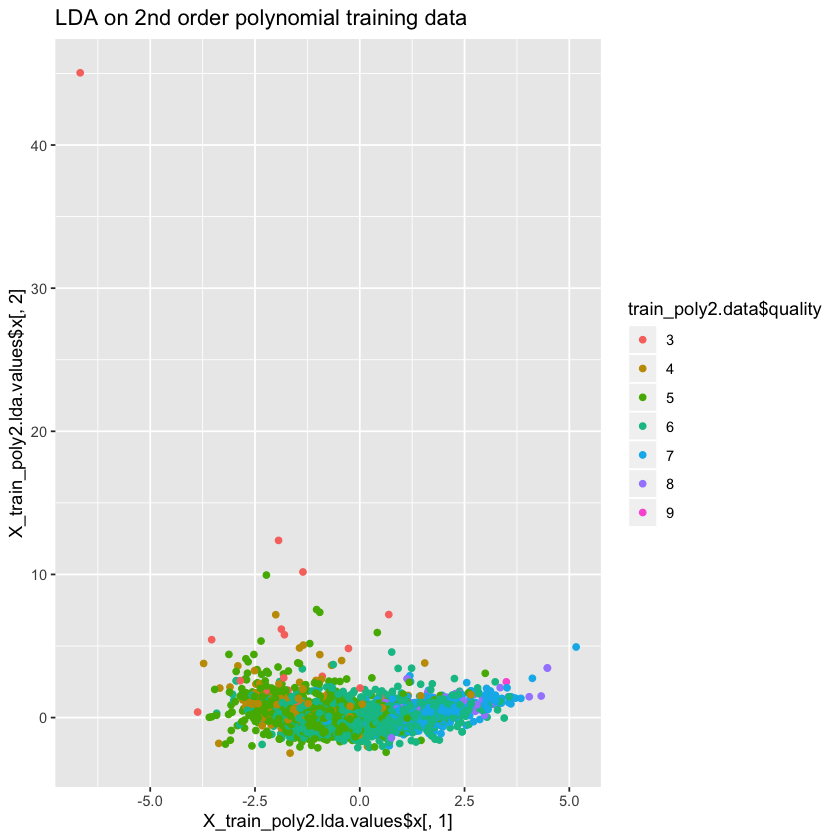

In [15]:
train_poly2.data$quality <- factor(y_train$quality)
test_poly2.data$quality <- factor(y_test$quality)

X_train_poly2.lda <- lda( quality~ ., data=train_poly2.data)

X_train_poly2.lda.values <- predict(X_train_poly2.lda)
X_test_poly2.lda.values <- predict(X_train_poly2.lda, newdata = X_test_poly2)

qplot(X_train_poly2.lda.values$x[,1], X_train_poly2.lda.values$x[,2], 
      colour = train_poly2.data$quality) + 
    ggtitle('LDA on 2nd order polynomial training data')

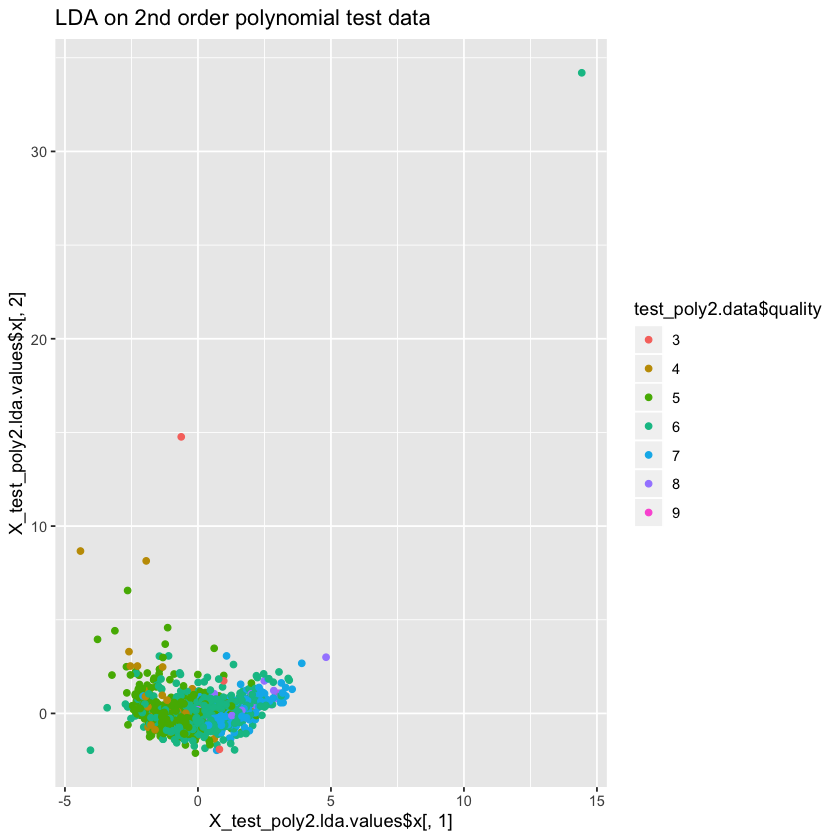

In [16]:
qplot(X_test_poly2.lda.values$x[,1], X_test_poly2.lda.values$x[,2], 
      colour = test_poly2.data$quality)+ 
ggtitle('LDA on 2nd order polynomial test data')

In [17]:
y_train$quality <- as.numeric(y_train$quality)
y_test$quality <- as.numeric(y_test$quality)

X_train_poly2_lda <-as.data.frame(X_train_poly2.lda.values$x)
X_test_poly2_lda <- as.data.frame(X_test_poly2.lda.values$x)

train_poly2_lda <- X_train_poly2_lda
train_poly2_lda["quality"] <- y_train

test_poly2_lda <- X_test_poly2_lda
test_poly2_lda["quality"] <- y_test

2. LDA for the 3rd order polynomial data

Warning message in lda.default(x, grouping, ...):
“variables are collinear”

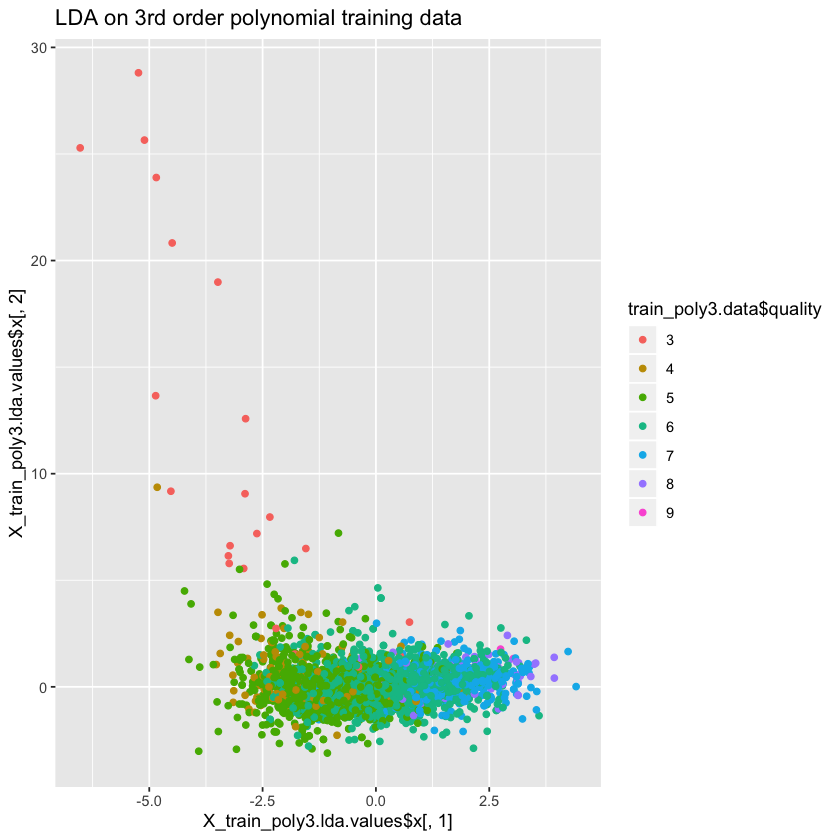

In [18]:
train_poly3.data$quality <- factor(y_train$quality)
test_poly3.data$quality <- factor(y_test$quality)

X_train_poly3.lda <- lda( quality~ ., data=train_poly3.data)

X_train_poly3.lda.values <- predict(X_train_poly3.lda)
X_test_poly3.lda.values <- predict(X_train_poly3.lda, newdata = X_test_poly3)

qplot(X_train_poly3.lda.values$x[,1], X_train_poly3.lda.values$x[,2], 
      colour = train_poly3.data$quality)
        + ggtitle('LDA on 3rd order polynomial training data')

### Comments:
Compared to the LDA of 2nd order polynomial, the LDA of the 3rd order polynomial move the data of quality 3 and 4 even futher away from the rest

It is clear from the graph above that we should build two model, one model for high quality  and one for low quality 

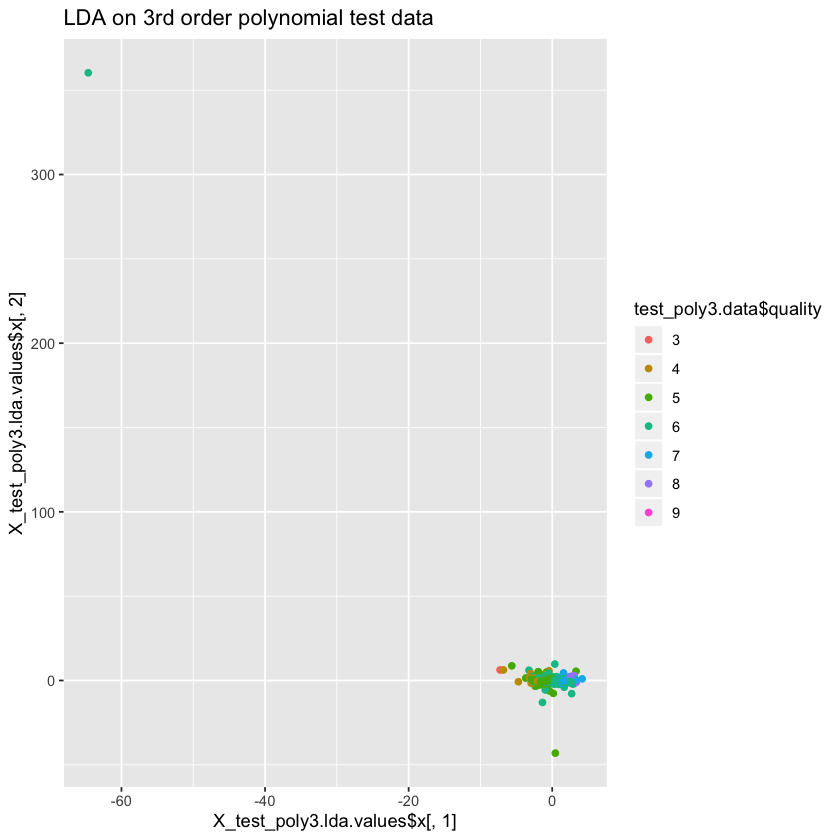

In [19]:
qplot(X_test_poly3.lda.values$x[,1], X_test_poly3.lda.values$x[,2], 
      colour = test_poly3.data$quality)
    + ggtitle('LDA on 3rd order polynomial test data')

In [20]:
y_train$quality <- as.numeric(y_train$quality)
y_test$quality <- as.numeric(y_test$quality)

X_train_poly3_lda <-as.data.frame(X_train_poly3.lda.values$x)
X_test_poly3_lda <- as.data.frame(X_test_poly3.lda.values$x)

train_poly3_lda <- X_train_poly3_lda
train_poly3_lda["quality"] <- y_train

test_poly3_lda <- X_test_poly3_lda
test_poly3_lda["quality"] <- y_test

### 3. Gaussian kernel function

At the time of the data challenge, I didn't find an R package with the kernel function I needed, therefore, I have coded it from scratch. The kernel trick can be understand as taking the distance of one data point to another as a new feature, the gaussian function is used here to smooth the output of this distance. It can be imagine as projecting the data to another space in which each axis means the distance between two points in the original data space. 

This part of the featuers were not used in the final model due to the high dimensionality of the data, the model training was taking too long

In [21]:
squared_exponential <- function(distance_1){
    return(exp(distance_1*distance_1 / -2))
    }

In [22]:
X_train_kern  = squared_exponential(pdist(X_train)) 
# take the pairwise distance of the training data, and filter with a guassian function  
X_test_kern = squared_exponential(cdist(X_test, X_train))
# take the pairwise distance of the training data and test data, and filter with a guassian function  

In [23]:
X_train_kern <-as.data.frame(X_train_kern)
X_test_kern <- as.data.frame(X_test_kern)

train_kern <- X_train_kern
train_kern["quality"] <- y_train

test_kern <- X_test_kern
test_kern["quality"] <- y_test

# Regression model using PLS

Build plsRglm model for 3 data set:

1. Original data set without normalization 
2. LDA extraction of 2nd order polynomial
3. LDA extraction of 3 order polynomial

### Model1 with gaussian on original dataset 

In [24]:
cv.modpls <- cv.plsRglm(quality~.,data=train.data, nt = 11, K = 5,
                      modele="pls-glm-family",family=gaussian())


Family: gaussian 
Link function: identity 

NK: 1 
Number of groups : 5 
1 
____************************************************____

Family: gaussian 
Link function: identity 

____Predicting X without NA neither in X nor in Y____
____Component____ 1 ____
____Component____ 2 ____
____Component____ 3 ____
____Component____ 4 ____
____Component____ 5 ____
____Component____ 6 ____
____Component____ 7 ____
____Component____ 8 ____
____Component____ 9 ____
____Component____ 10 ____
____Component____ 11 ____
****________________________________________________****

2 
____************************************************____

Family: gaussian 
Link function: identity 

____Predicting X without NA neither in X nor in Y____
____Component____ 1 ____
____Component____ 2 ____
____Component____ 3 ____
____Component____ 4 ____
____Component____ 5 ____
____Component____ 6 ____
____Component____ 7 ____
____Component____ 8 ____
____Component____ 9 ____
____Component____ 10 ____
____Component____ 11 _

In [25]:
res.cv.modpls<-cvtable(summary(cv.modpls))

____************************************************____

Family: gaussian 
Link function: identity 

____Component____ 1 ____
____Component____ 2 ____
____Component____ 3 ____
____Component____ 4 ____
____Component____ 5 ____
____Component____ 6 ____
____Component____ 7 ____
____Component____ 8 ____
____Component____ 9 ____
____Component____ 10 ____
____Component____ 11 ____
____Predicting X without NA neither in X or Y____
****________________________________________________****


NK: 1

CV Q2Chi2 criterion:
0 1 
0 1 

CV PreChi2 criterion:
1 2 3 4 5 6 7 8 9 
0 0 0 0 0 0 0 0 1 


From the cross validation, I chosen to follow the CV PreChi2 criterion and use 8 compoents

____************************************************____

Family: gaussian 
Link function: identity 

____Component____ 1 ____
____Component____ 2 ____
____Component____ 3 ____
____Component____ 4 ____
____Component____ 5 ____
____Component____ 6 ____
____Component____ 7 ____
____Component____ 8 ____
____Predicting X without NA neither in X or Y____
****________________________________________________****



Warning message in model.matrix.default(mt, mf, contrasts):
“non-list contrasts argument ignored”

MAE,Rsquare
<dbl>,<dbl>
0.5645712,0.3056814


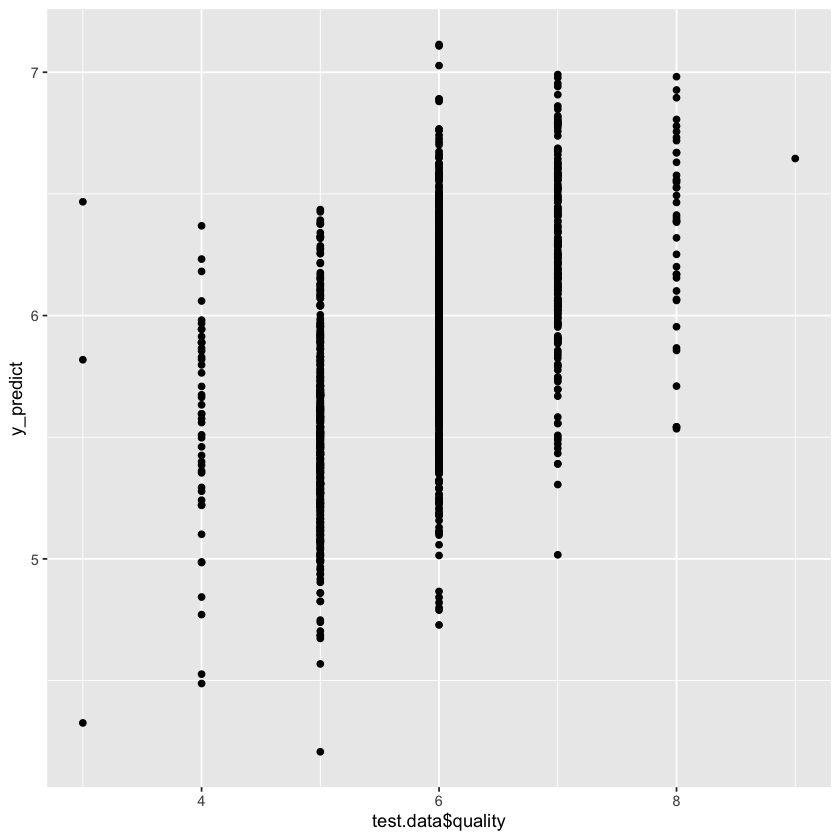

In [26]:
modpls_1 <-plsRglm(quality~.,data=train.data,8,
                      modele="pls-glm-family",family=gaussian())

y_predict <- predict(modpls_1, newdata = X_test)
y_predict <- data.frame(y_predict)

y_predict %>%
  ggplot(aes(test.data$quality, y_predict)) +
    geom_point()

data.frame(
  MAE = caret::MAE(y_predict$y_predict, y_test$quality),
  Rsquare = caret::R2(y_predict$y_predict, y_test$quality)
)



#### variable to save all prediction, prepare for averaging

In [27]:
final_predict = matrix(nrow = nrow(y_predict), ncol = 3)

In [28]:
final_predict[,1]  <- y_predict$y_predict

### Model2, poly2 + LDA

In [29]:
cv.modpls <- cv.plsRglm(quality~.,data=train_poly2_lda, nt = 11, K = 5,
                      modele="pls-glm-family",family=gaussian())


Family: gaussian 
Link function: identity 

NK: 1 
Number of groups : 5 
1 
____************************************************____

Family: gaussian 
Link function: identity 

____Predicting X without NA neither in X nor in Y____
____Component____ 1 ____
____Component____ 2 ____
____Component____ 3 ____
____Component____ 4 ____
____Component____ 5 ____
____Component____ 6 ____
Warning only 6 components could thus be extracted
****________________________________________________****

2 
____************************************************____

Family: gaussian 
Link function: identity 

____Predicting X without NA neither in X nor in Y____
____Component____ 1 ____
____Component____ 2 ____
____Component____ 3 ____
____Component____ 4 ____
____Component____ 5 ____
____Component____ 6 ____
Warning only 6 components could thus be extracted
****________________________________________________****

3 
____************************************************____

Family: gaussian 
Link function

In [30]:
res.cv.modpls<-cvtable(summary(cv.modpls))

____************************************************____

Family: gaussian 
Link function: identity 

____Component____ 1 ____
____Component____ 2 ____
____Component____ 3 ____
____Component____ 4 ____
____Component____ 5 ____
____Component____ 6 ____
Warning only 6 components could thus be extracted
____Predicting X without NA neither in X or Y____
****________________________________________________****


NK: 1

CV Q2Chi2 criterion:
0 1 
0 1 

CV PreChi2 criterion:
1 
1 


____************************************************____

Family: gaussian 
Link function: identity 

____Component____ 1 ____
____Predicting X without NA neither in X or Y____
****________________________________________________****



Warning message in model.matrix.default(mt, mf, contrasts):
“non-list contrasts argument ignored”

MAE,Rsquare
<dbl>,<dbl>
0.5531245,0.3277317


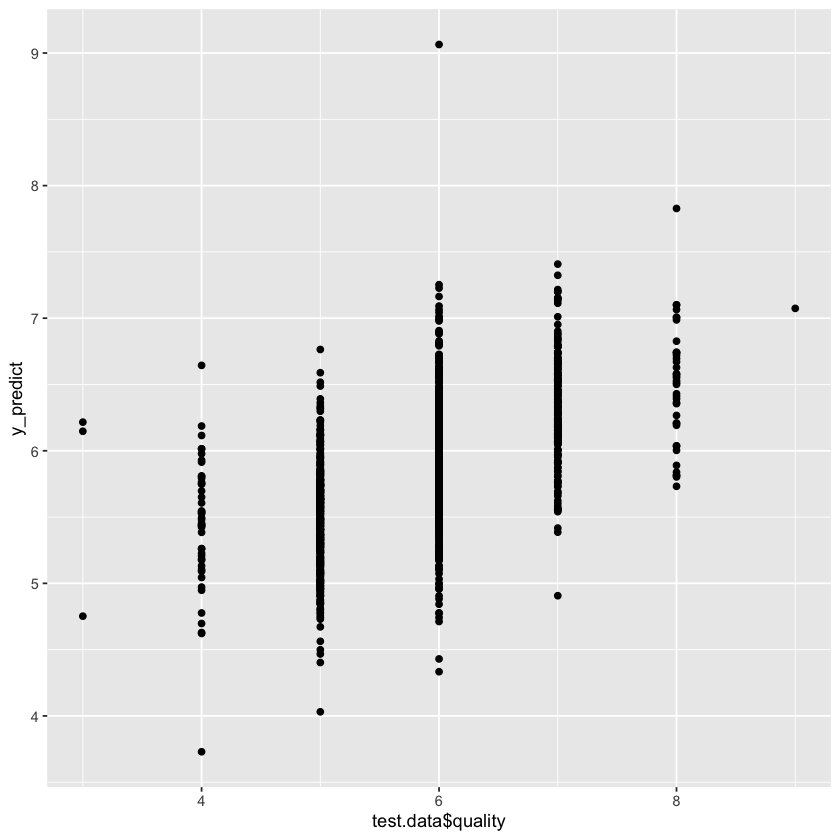

In [31]:
modpls_2 <-plsRglm(quality~.,data=train_poly2_lda,1,
                      modele="pls-glm-family",family=gaussian())

y_predict <- predict(modpls_2, newdata = X_test_poly2_lda)
y_predict <- data.frame(y_predict)

y_predict %>%
  ggplot(aes(test.data$quality, y_predict)) +
    geom_point()

data.frame(
  MAE = caret::MAE(y_predict$y_predict, y_test$quality),
  Rsquare = caret::R2(y_predict$y_predict, y_test$quality)
)



In [32]:
final_predict[,2]  <- y_predict$y_predict

### Model3, poly3 + LDA

In [33]:
cv.modpls <- cv.plsRglm(quality~.,data=train_poly2_lda, nt = 11, K = 5,
                      modele="pls-glm-family",family=gaussian())


Family: gaussian 
Link function: identity 

NK: 1 
Number of groups : 5 
1 
____************************************************____

Family: gaussian 
Link function: identity 

____Predicting X without NA neither in X nor in Y____
____Component____ 1 ____
____Component____ 2 ____
____Component____ 3 ____
____Component____ 4 ____
____Component____ 5 ____
____Component____ 6 ____
Warning only 6 components could thus be extracted
****________________________________________________****

2 
____************************************************____

Family: gaussian 
Link function: identity 

____Predicting X without NA neither in X nor in Y____
____Component____ 1 ____
____Component____ 2 ____
____Component____ 3 ____
____Component____ 4 ____
____Component____ 5 ____
____Component____ 6 ____
Warning only 6 components could thus be extracted
****________________________________________________****

3 
____************************************************____

Family: gaussian 
Link function

In [34]:
res.cv.modpls<-cvtable(summary(cv.modpls)) 

____************************************************____

Family: gaussian 
Link function: identity 

____Component____ 1 ____
____Component____ 2 ____
____Component____ 3 ____
____Component____ 4 ____
____Component____ 5 ____
____Component____ 6 ____
Warning only 6 components could thus be extracted
____Predicting X without NA neither in X or Y____
****________________________________________________****


NK: 1

CV Q2Chi2 criterion:
0 1 
0 1 

CV PreChi2 criterion:
1 2 
0 1 


____************************************************____

Family: gaussian 
Link function: identity 

____Component____ 1 ____
____Component____ 2 ____
____Component____ 3 ____
____Predicting X without NA neither in X or Y____
****________________________________________________****



Warning message in model.matrix.default(mt, mf, contrasts):
“non-list contrasts argument ignored”

MAE,Rsquare
<dbl>,<dbl>
0.5620449,0.1410789


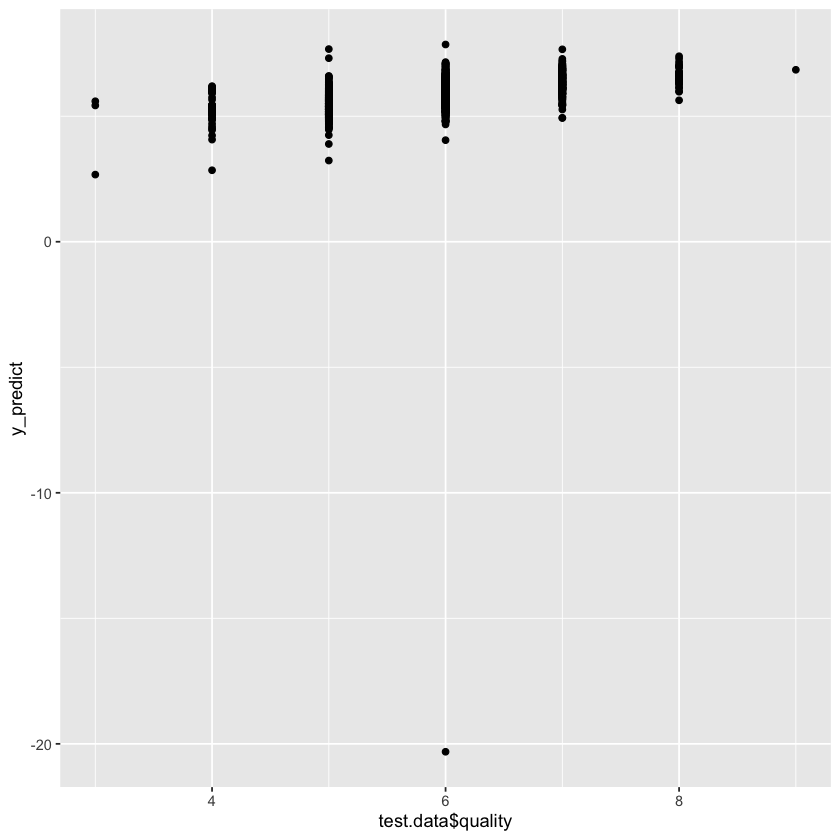

In [35]:
modpls_3 <-plsRglm(quality~.,data=train_poly3_lda,3,
                      modele="pls-glm-family",family=gaussian())

y_predict <- predict(modpls_3, newdata = X_test_poly3_lda)
y_predict <- data.frame(y_predict)

y_predict %>%
  ggplot(aes(test.data$quality, y_predict)) +
    geom_point()

data.frame(
  MAE = caret::MAE(y_predict$y_predict, y_test$quality),
  Rsquare = caret::R2(y_predict$y_predict, y_test$quality)
)



In [36]:
final_predict[,3]  <- y_predict$y_predict

### Average the prediction

In [37]:
final = rowMeans(final_predict, na.rm = FALSE, dims = 1)

In [38]:
final = as.data.frame(final)

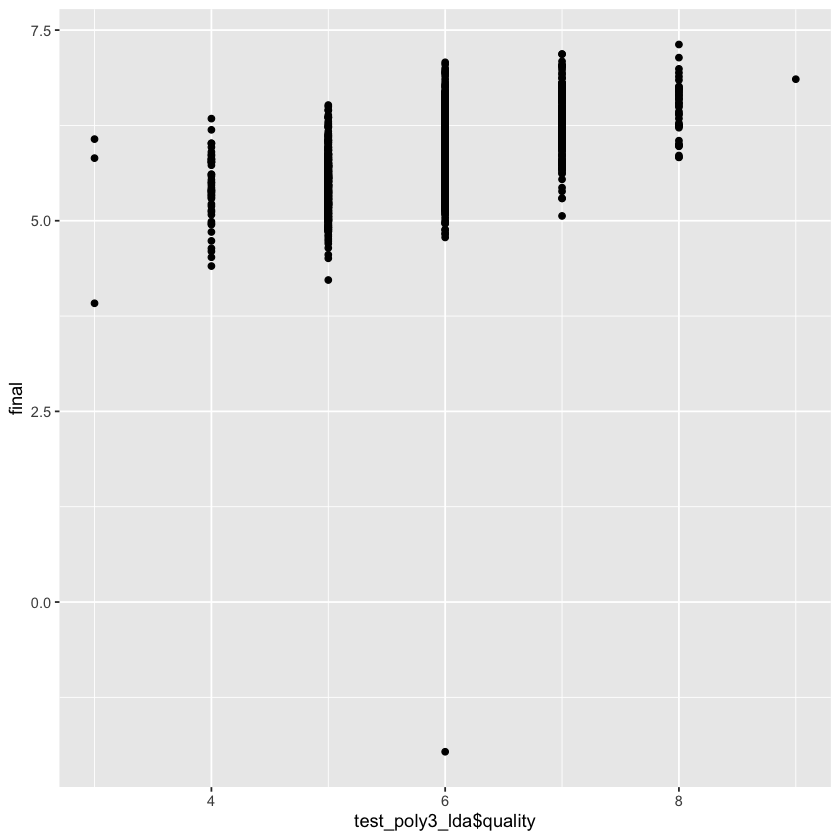

In [39]:
final %>%
  ggplot(aes(test_poly3_lda$quality, final)) +
    geom_point()

In [40]:
data.frame(
  MAE = caret::MAE(final$final, y_test$quality),
  Rsquare = caret::R2(final$final, y_test$quality)
)

MAE,Rsquare
<dbl>,<dbl>
0.5424934,0.3112283
